# Learning a communication channel

This model shows how to include synaptic plasticity in nengo models using the hPES
learning rule. You will implement error-driven learning to learn to compute a simple
communication channel. This is done by using an error signal provided by a neural
ensemble to modulate the connection between two other ensembles.

In [1]:
# Setup the environment
import numpy as np

import nengo
from nengo.processes import WhiteSignal

## Create the Model

The model has parameters as described in the book. Note that hPES learning rule is built
into Nengo 1.4 as mentioned in the book. The same rule can be implemented in Nengo 2.0
by combining the PES and the BCM rule as shown in the code.  Also, instead of using the
"gate" and "switch" as described in the book, an "inhibit" population is used which
serves the same purpose of turning off the learning by inhibiting the error population.

Note that to compute the actual error value (which is required only for analysis), the
book
uses a population of "Direct" mode neurons. In Nengo 2.0, this can be done more
efficiently
using a `nengo.Node()`.

When you run the model, you will see that the `post` population gradually learns to
compute the communication channel. In the model, you will inhibit the error population
after 15 seconds to turn off learning and you will see that the `post` population will
still track the `pre` population showing that the model has actually learned the input.

The model can also learn other functions by using an appropriate error signal. For
example to learn a square function, comment out the lines
marked `# Learn the communication channel` and uncomment the lines
marked `# Learn the square function` in the code. Run the model again and you will
see that the model successfully learns the square function.

In [2]:
# Create the network object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Learning", seed=7)
with model:
    # Ensembles to represent populations
    pre = nengo.Ensemble(50, dimensions=1, label="Pre")
    post = nengo.Ensemble(50, dimensions=1, label="Post")

    # Ensemble to compute the learning error signal
    error = nengo.Ensemble(100, dimensions=1, label="Learning Error")

    # Node to compute the actual error value
    actual_error = nengo.Node(size_in=1, label="Actual Error")

    # Learn the communication channel
    nengo.Connection(pre, actual_error, transform=-1)
    nengo.Connection(pre, error, transform=-1, synapse=0.02)

    # Learn the square function
    # nengo.Connection(pre, actual_error, function=lambda x: x**2, transform=-1)
    # nengo.Connection(pre, error, function=lambda x: x**2, transform=-1)

    # Error = pre - post
    nengo.Connection(post, actual_error, transform=1)
    nengo.Connection(post, error, transform=1, synapse=0.02)

    # Connecting pre population to post population (communication channel)
    conn = nengo.Connection(
        pre,
        post,
        function=lambda x: np.random.random(1),
        solver=nengo.solvers.LstsqL2(weights=True),
    )

    # Adding the learning rule to the connection
    conn.learning_rule_type = {
        "my_pes": nengo.PES(),
        "my_bcm": nengo.BCM(learning_rate=1e-10),
    }

    # Error connections don't impart current
    error_conn = nengo.Connection(error, conn.learning_rule["my_pes"])

    # Providing input to the model
    stim = nengo.Node(WhiteSignal(30, high=10), label="Input")  # RMS = 0.5 by default
    nengo.Connection(stim, pre, synapse=0.02)  # Connect the input to the pre ensemble

    # Function to inhibit the error population after 15s
    def inhib(t):
        return 2.0 if t > 15.0 else 0.0

    # Connecting inhibit population to error population
    inhibit = nengo.Node(inhib, label="Inhibit")
    nengo.Connection(
        inhibit, error.neurons, transform=[[-3]] * error.n_neurons, synapse=0.01
    )

## Run the Model

In [ ]:
# Import the nengo_gui visualizer to run and visualize the model.
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch6-learn.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs
as shown in the figure below.

You will see that the `Post` population doesn't initially track the `Pre` population but
eventually it learns the function (which is a communication channel in this case) and
starts tracking the post population. After the `Error` ensemble is inhibited (i.e., t >
15s -- shown by a value of zero on the `Learned Error` plot), the `Post` population
continues to track the `Pre` population.

The `Actual Error` graph shows that there is significant error between the `Pre`
and the `Post` populations at the beginning which eventually gets reduced
as model learns the communication channel.

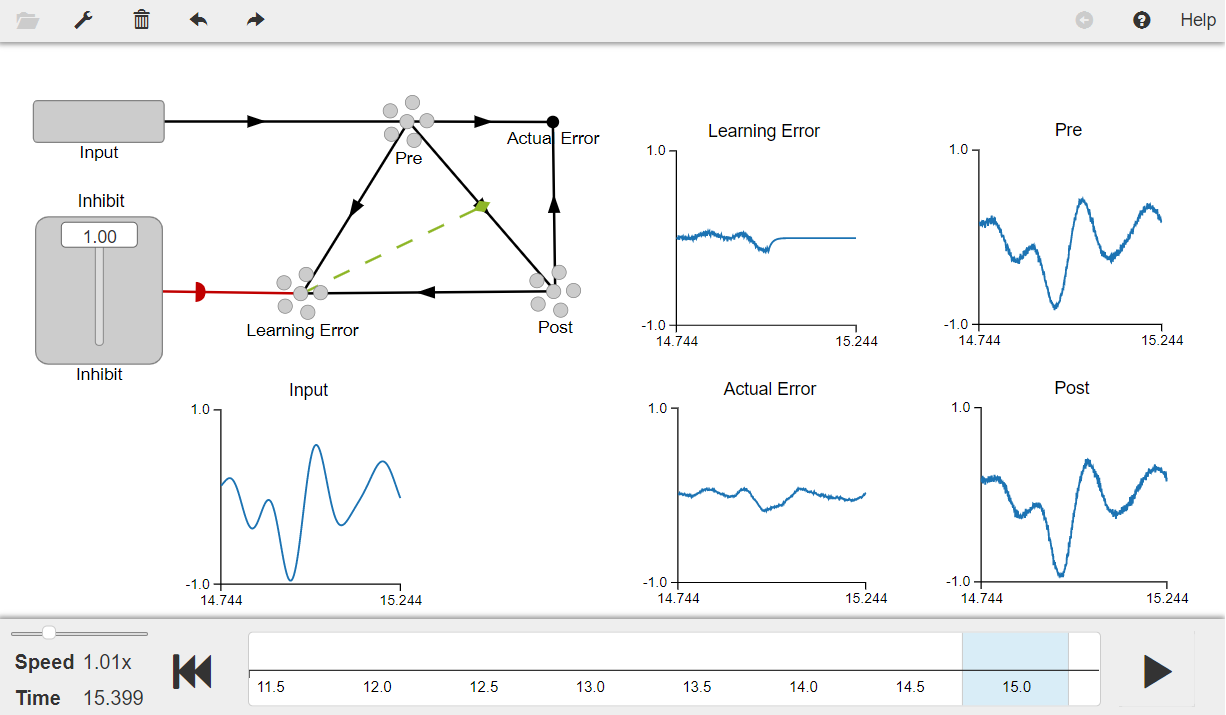

In [3]:
from IPython.display import Image

Image(filename="ch6-learn.png")